In [1]:
import openpyxl
import warnings
import catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ks_2samp
from scipy.stats import boxcox

warnings.filterwarnings("ignore")

# Import Data

In [2]:
train = pd.read_excel("train.xlsx", engine="openpyxl")
test = pd.DataFrame(pd.read_excel("test.xlsx", engine="openpyxl"))
submit_ex = pd.DataFrame(pd.read_excel("sample_submission.xlsx", engine="openpyxl"))

In [3]:
freight = pd.read_excel("Грузоперевозки.xlsx")
market = pd.read_excel("Данные рынка стройматериалов.xlsx")
index_LME = pd.read_excel("Индекс LME.xlsx")
macromarks = pd.read_excel("Макропоказатели.xlsx")
market_fe = pd.read_excel("Показатели рынка металла.xlsx")
fuel = pd.read_excel("Топливо.xlsx")
price = pd.read_excel("Цены на сырье.xlsx")

In [4]:
severstal = pd.read_csv("CHMF Акции.csv")
magnitogorsk = pd.read_csv("MAGN Акции.csv")
novolipetsk = pd.read_csv("NLMK Акции.csv")

In [5]:
magnitogorsk.rename(columns={"Дата":"Date", "Цена":"Price", "Откр.":"Open","Макс.":"High", "Мин.":"Low", "Объём":"Vol.", "Изм. %":"Change %"}, 
                   inplace=True)

# EDA

In [6]:
freight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   dt                               302 non-null    datetime64[ns]
 1   Индекс стоимости грузоперевозок  302 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.8 KB


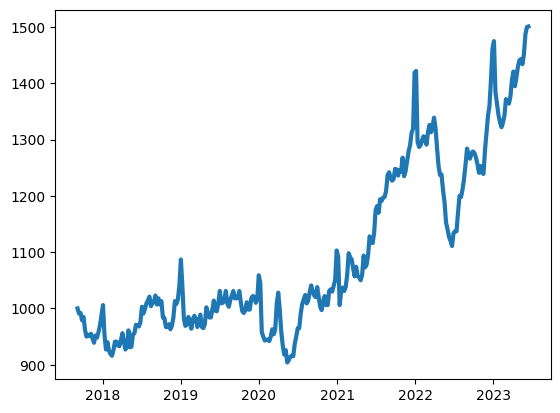

In [7]:
plt.plot(freight["dt"], freight.iloc[:, 1], linewidth=3)

In [8]:
adfuller(freight.iloc[:, 1])

(0.433908057418788,
 0.982719641984124,
 13,
 288,
 {'1%': -3.453261605529366,
  '5%': -2.87162848654246,
  '10%': -2.5721455328896603},
 2522.077560983369)

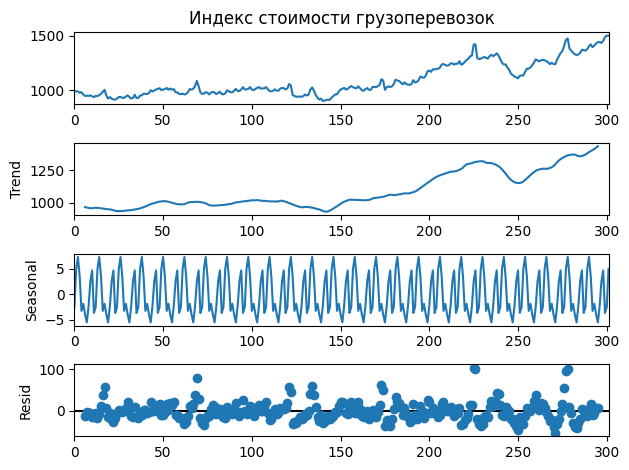

<Figure size 2000x2000 with 0 Axes>

In [9]:
fig = seasonal_decompose(freight.iloc[:, 1], period=12).plot()
plt.figure(figsize=(20, 20))
plt.show()

Временной ряд для индекса стоимости грузоперевозок имеет тренд, ошибка случайна, ярко выраженной сезонности не наблюдается.

В качестве предобработки: дифференцирование ВР

In [10]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             25 non-null     datetime64[ns]
 1   Импорт цемента ЖД              25 non-null     float64       
 2   Экспорт цемента ЖД             25 non-null     float64       
 3   Отгрузка цемента хоппер ЖД     25 non-null     float64       
 4   Отгрузка цемента остальные ЖД  25 non-null     float64       
 5   Производство цемента           25 non-null     float64       
 6   Импорт цемента                 25 non-null     float64       
 7   Экспорт цемента                25 non-null     float64       
 8   Потребление цемента            25 non-null     float64       
 9   Отгрузка цемента               25 non-null     float64       
 10  Цена цемента с НДС             25 non-null     float64       
 11  Цена цемента без НДС 

In [11]:
results = {}
for colname in market.columns[1:]:
    if adfuller(market[colname])[1] > 0.05:
        results[colname] = adfuller(market[colname])[1]
results

{'Импорт цемента ЖД': 0.64321232334529,
 'Экспорт цемента ЖД': 0.9749341993857542,
 'Экспорт цемента': 0.9888548646094755,
 'Потребление цемента': 0.1846868298637398,
 'Отгрузка цемента': 0.951779240908717,
 'Цена цемента с НДС': 0.45426574690457944,
 'Цена цемента без НДС': 0.9946459978288048,
 'Производство бетона РФ': 0.8499400508035624,
 'Производство бетона МО': 0.19616926727194278}

Представленные ряды не стационарны и требуют дифференцирования

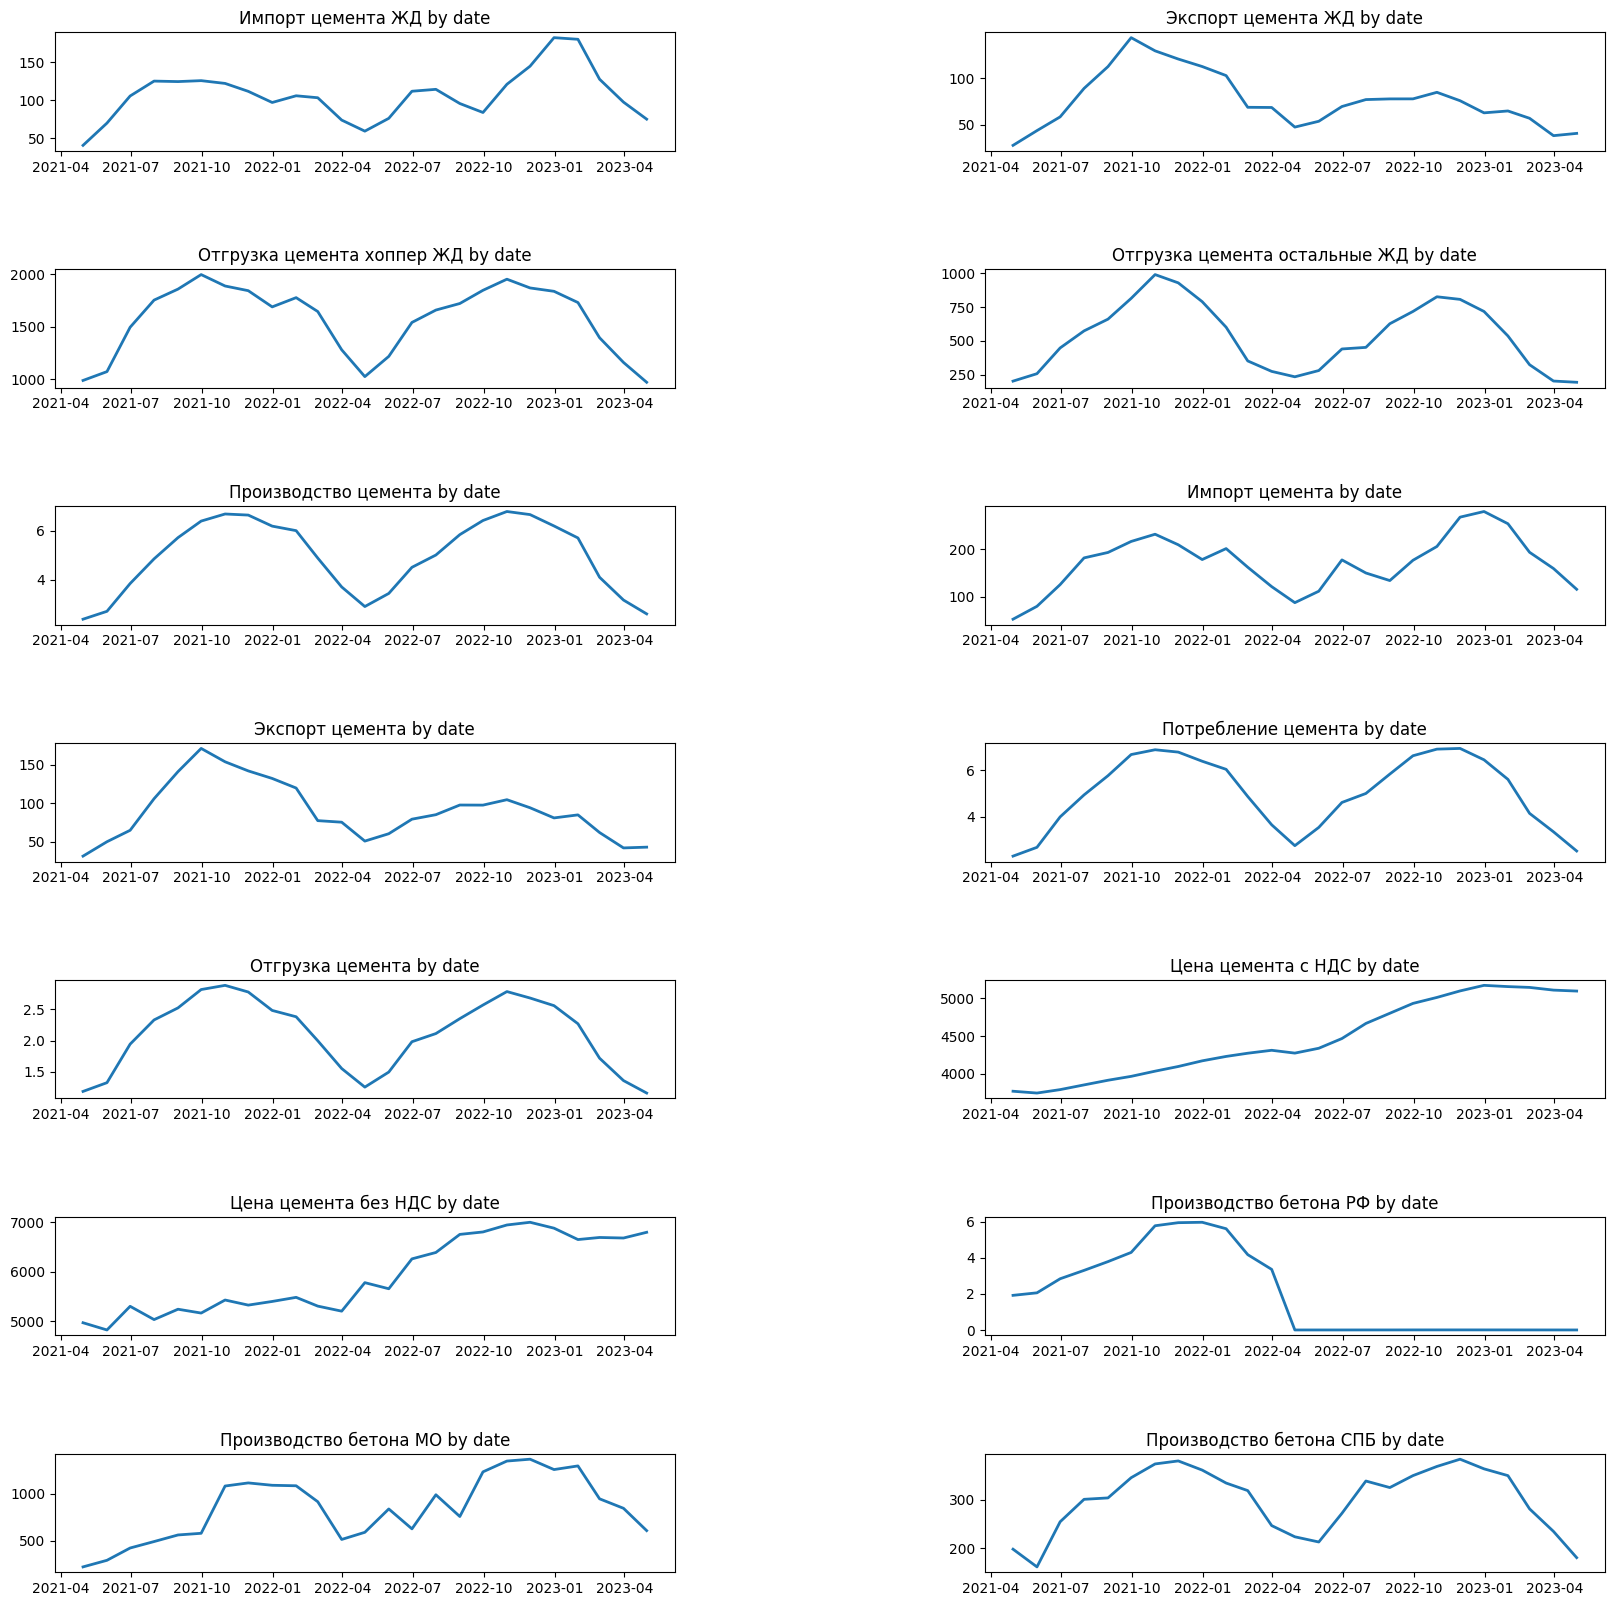

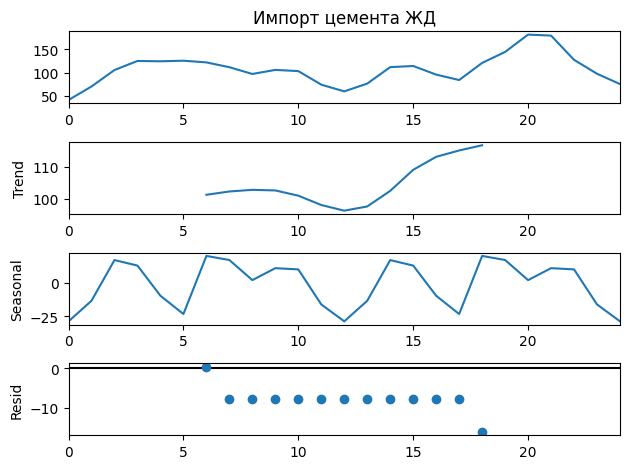

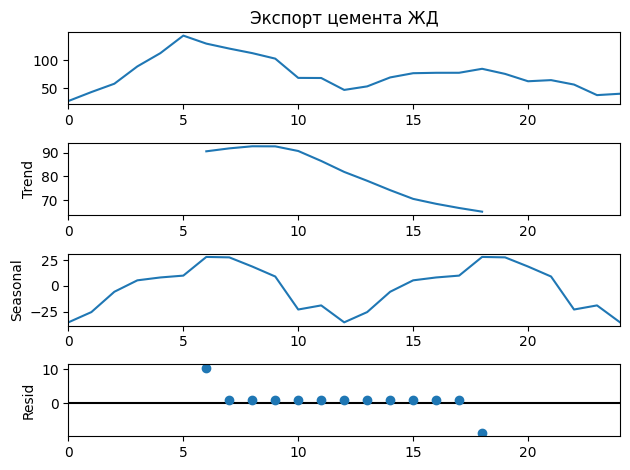

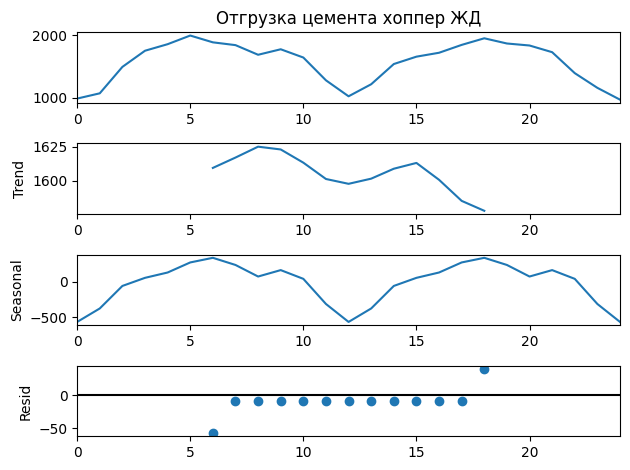

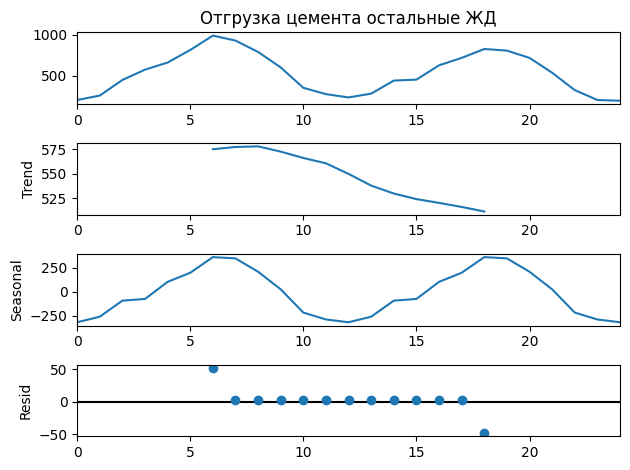

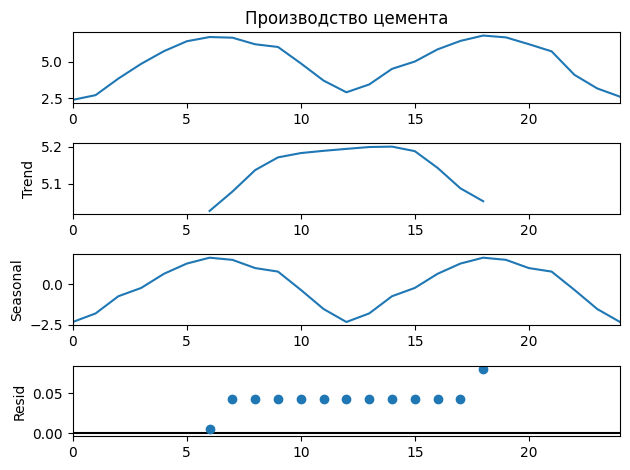

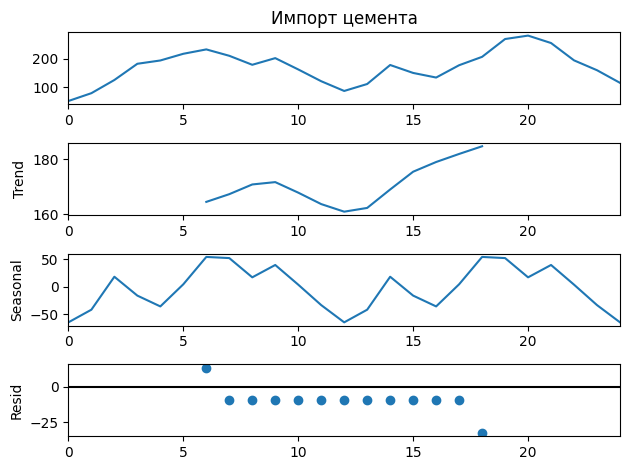

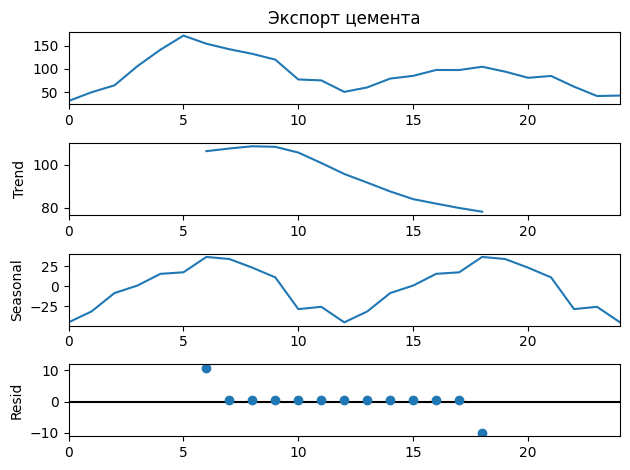

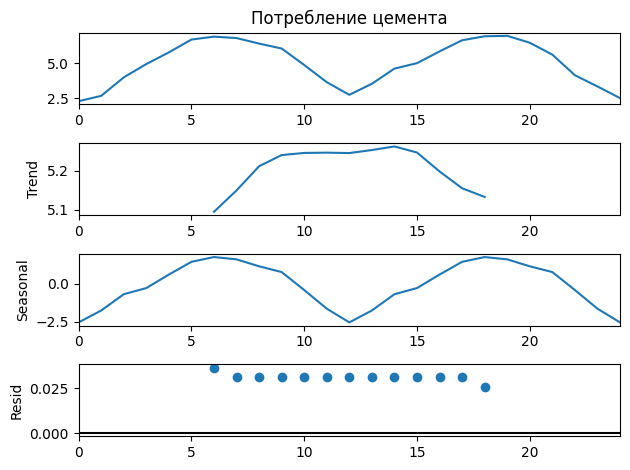

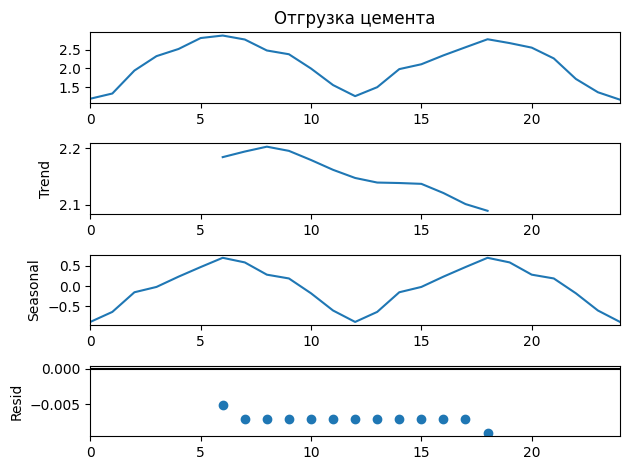

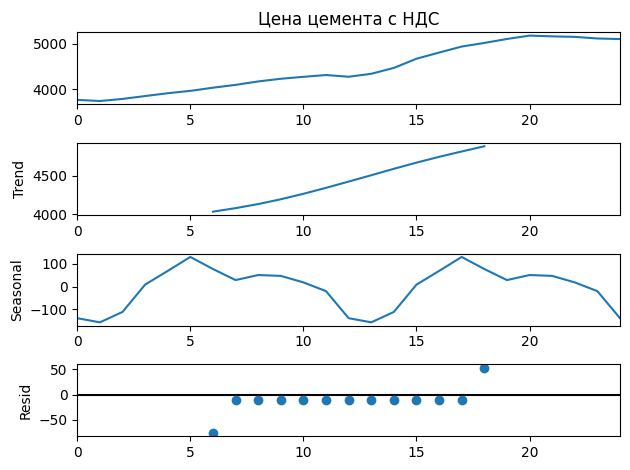

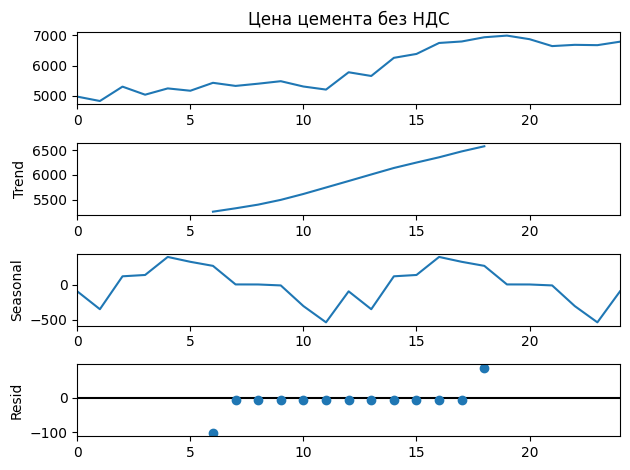

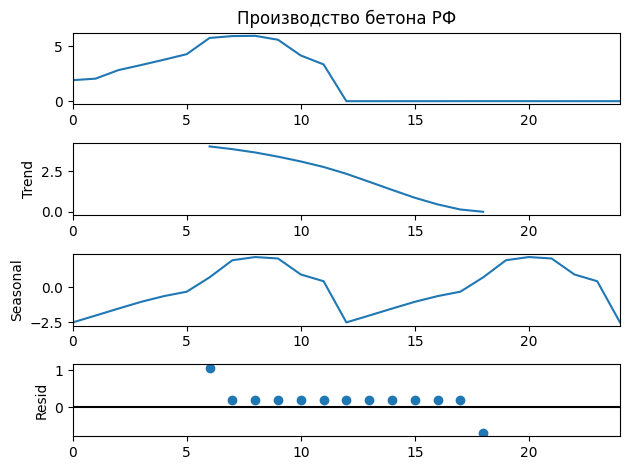

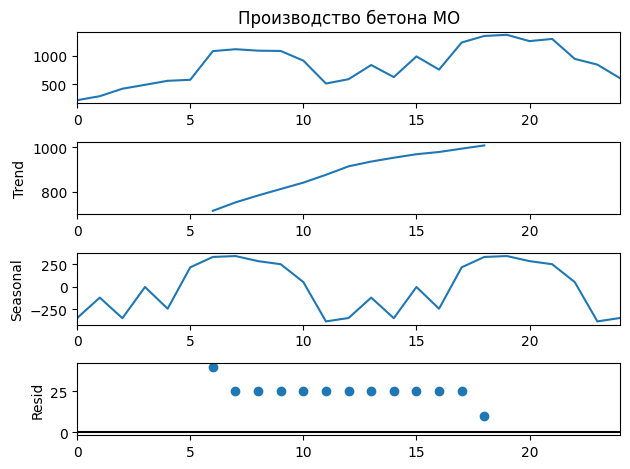

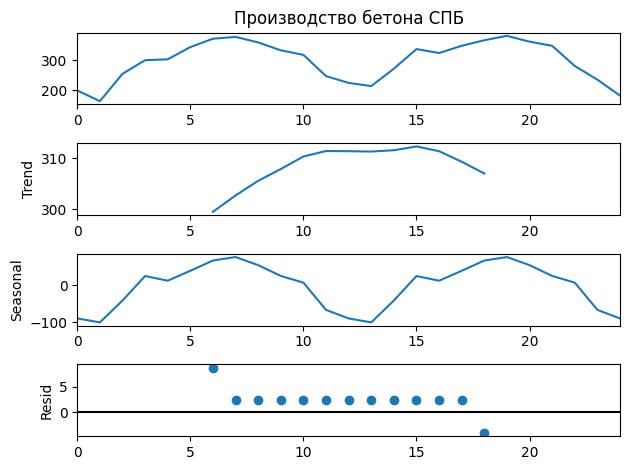

In [12]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20, 20))

plt.subplots_adjust(wspace=0.5, hspace=1)
for ax, colname in zip(axs.flat, market.columns[1:]):
    fig = seasonal_decompose(market[colname], period=12).plot()
    ax.plot(market["dt"], market[colname], linewidth=2)
    ax.set_title(f"{colname} by date")

Многие временные ряды из представленных сезонны с периодом чуть более, чем год -> следует обратить внимание, так как могут 
оказывать влияние на сезонность цены

Также, большинство ВР из прелставленных имеют одинаковое распределение, что можно использовать для упрощения дальнейшей предобработки данных

In [13]:
index_LME.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   дата    516 non-null    datetime64[ns]
 1   цена    517 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.2+ KB


In [14]:
adfuller(index_LME.iloc[:516, 1])[1]

0.12388772932204312

Ряд не стационарен

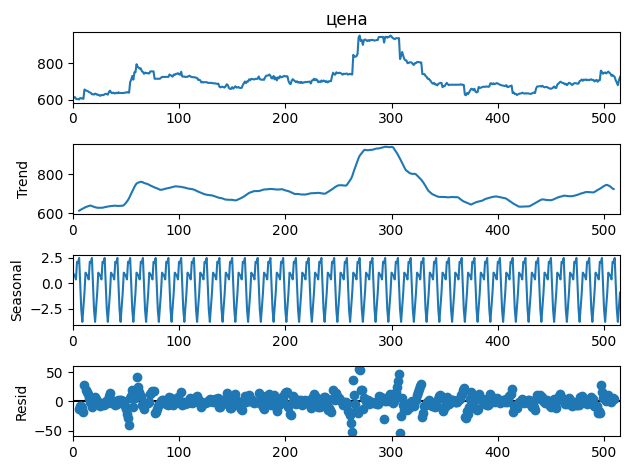

<Figure size 2000x2000 with 0 Axes>

In [15]:
fig = seasonal_decompose(index_LME.iloc[:516, 1], period=12).plot()
plt.figure(figsize=(20, 20))
plt.show()

(array([18718., 18809., 18901., 18993., 19083., 19174., 19266., 19358.,
        19448.]),
 [Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04')])

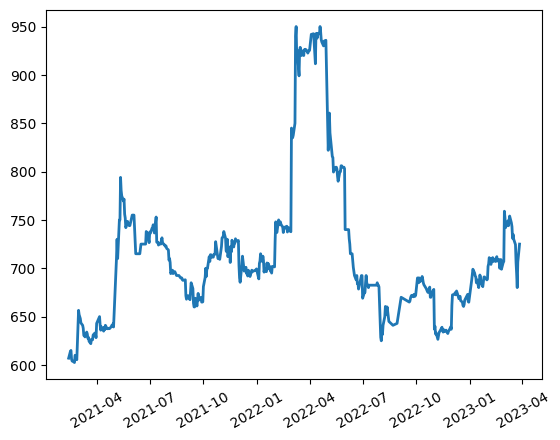

In [16]:
plt.plot(index_LME.iloc[:516, 0], index_LME.iloc[:516, 1], linewidth=2)
plt.xticks(rotation=30)

Представленный ВР не обладает ярко выраженным трендом, имеет слабую сезонность и небольшую дисперсию

In [17]:
macromarks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672 entries, 0 to 1671
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   dt                                                     1672 non-null   datetime64[ns]
 1   Базовый индекс потребительских цен на товары и услуги  29 non-null     float64       
 2   Ключевая ставка                                        1365 non-null   float64       
 3   Курс доллара                                           1338 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 52.4 KB


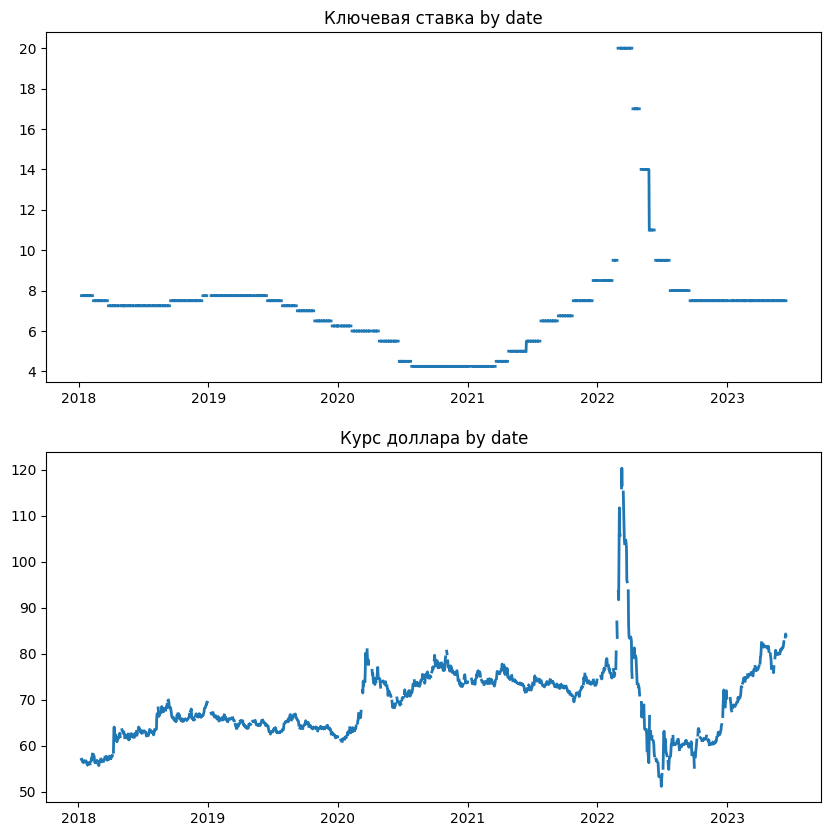

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.2)
for ax, colname in zip(axs.flat, macromarks.columns[2:]):
    ax.plot(macromarks["dt"], macromarks[colname], linewidth=2)
    ax.set_title(f"{colname} by date")

Действительно, как оказалось, БИПЦ измеряется в последний день текущего месяца (только с 2021 года), после чего меняет свою периодичнсоть; необходимо будет восстановить значения данного показателя, так как о нём почти ничего неизвестно

Курс доллара обладает неоднородным периодом измерений

Дискретность ставки нестрашна, достаточно всего лишь доопределить её на неизвестных участках константной функцией

In [22]:
market_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 81 columns):
 #   Column                                                                 Non-Null Count  Dtype         
---  ------                                                                 --------------  -----         
 0   dt                                                                     85 non-null     datetime64[ns]
 1   Производство арматуры Сортовой прокат_Арматура                         85 non-null     int64         
 2   Производство арматуры Сортовой прокат_Катанка                          85 non-null     int64         
 3   Производство арматуры Сортовой прокат_Прутки прочие                    85 non-null     int64         
 4   Производство сырья ЖРС_Агломерат                                       85 non-null     int64         
 5   Производство сырья ЖРС_Аглоруда                                        85 non-null     int64         
 6   Производство сырья ЖРС_Концентрат   

In [23]:
results = {}
for colname in market_fe.columns[1:]:
    if adfuller(market_fe[colname].fillna(np.mean(market_fe[colname])))[1] > 0.05:
        results[colname] = adfuller(market_fe[colname].fillna(np.mean(market_fe[colname])))[1]
results
len(results)

49

Количество нестационарных рядов для приведённого набора данных -> необходимо дифференцировать

In [24]:
fuel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   dt              76 non-null     datetime64[ns]
 1   Цена на бензин  76 non-null     float64       
 2   Цена на дт      76 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.9 KB


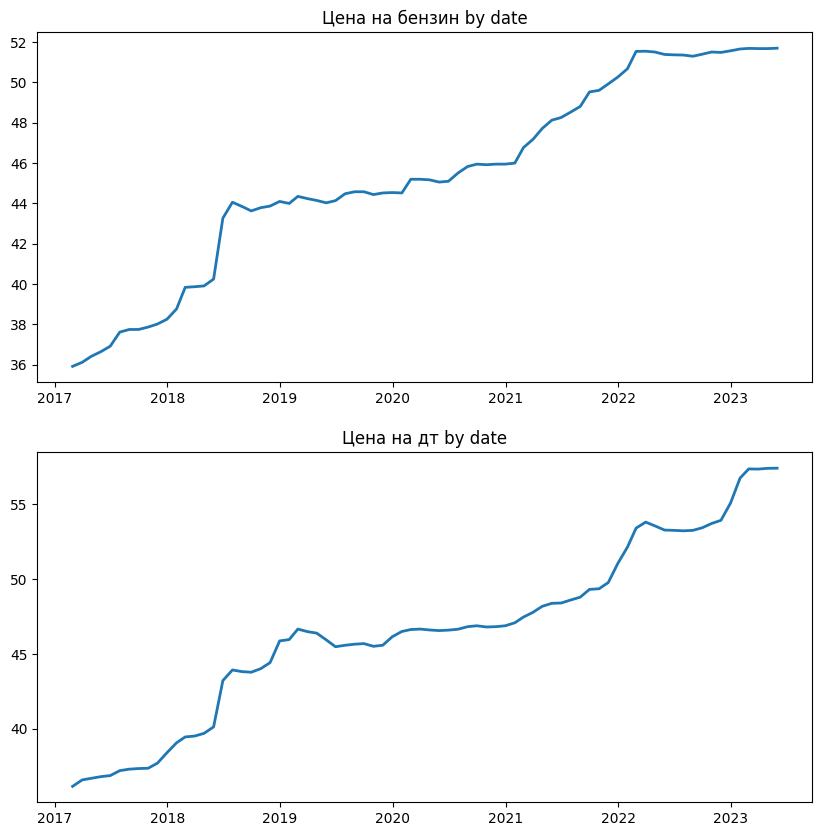

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.2)
for ax, colname in zip(axs.flat, fuel.columns[1:]):
    ax.plot(fuel["dt"], fuel[colname], linewidth=2)
    ax.set_title(f"{colname} by date")

In [27]:
results = {}
for colname in fuel.columns[1:]:
    if adfuller(fuel[colname])[1] > 0.05:
        results[colname] = adfuller(fuel[colname])[1]
results

{'Цена на бензин': 0.4111402344259974, 'Цена на дт': 0.9002400541024536}

Оба ряда нестационарны, обладают ярко выраженным трендом, при этом имеют схожее, практически одинаковое, распределение

In [29]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 59 columns):
 #   Column                                                                                            Non-Null Count  Dtype         
---  ------                                                                                            --------------  -----         
 0   dt                                                                                                423 non-null    datetime64[ns]
 1   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС                                  423 non-null    int64         
 2   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т                                                          423 non-null    int64         
 3   Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС                                                      423 non-null    int64         
 4   Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС                                      

In [32]:
groups = {
    "лом_3а":[], "чугун":[], "окатыши fe":[], "лом_hms":[],
    "концентрат коксующегося угля":[], "аглоруда fe":[],
    "концентрат fe":[], "гбж":[], "средневзвешенная цена за 1 %":[]
}
for colname in price.columns[1:]:
    for group in groups.keys():
        if group in colname.lower():
            groups[group].append(colname)
            break
    else:
        print(colname)
groups["концентрат коксующегося угля"].append("Кокс_Россия Урал Сибирь +25, FCA руб./т., без НДС")
groups["аглоруда fe"].append("ЖРС_Китай Iron ore fines Fe 62%, CFR")
lom = "Лом_Б26 легированный (Ni 9,3%), РФ CPT, руб./т, без НДС"
np.sum([len(groups[group]) for group in groups.keys()])

ЖРС_Китай Iron ore fines Fe 62%, CFR
Лом_Б26 легированный (Ni 9,3%), РФ CPT, руб./т, без НДС
Кокс_Россия Урал Сибирь +25, FCA руб./т., без НДС


57

Данное число показывает, какое количество типов товаров (от различных производителей), оказалось в группе схожих; одна группа товара - Лом_Б26 
легированный остался без группы

In [ ]:
for group in groups:
    for first_s in range(len(groups[group])-1):
        for sec_s in range(first_s, len(groups[group])):
            if ks_2samp(price[groups[group][first_s]], price[groups[group][sec_s]])[1] <= 0.05:
                print(f"{group}: {groups[group][first_s]} and {groups[group][sec_s]}; p-val:{ks_2samp(price[groups[group][first_s]], price[groups[group][sec_s]])[1]}")

Данная проверка позволяет определить однородность (в плане похожести распределения) ВР, оказавшихся в одной группе

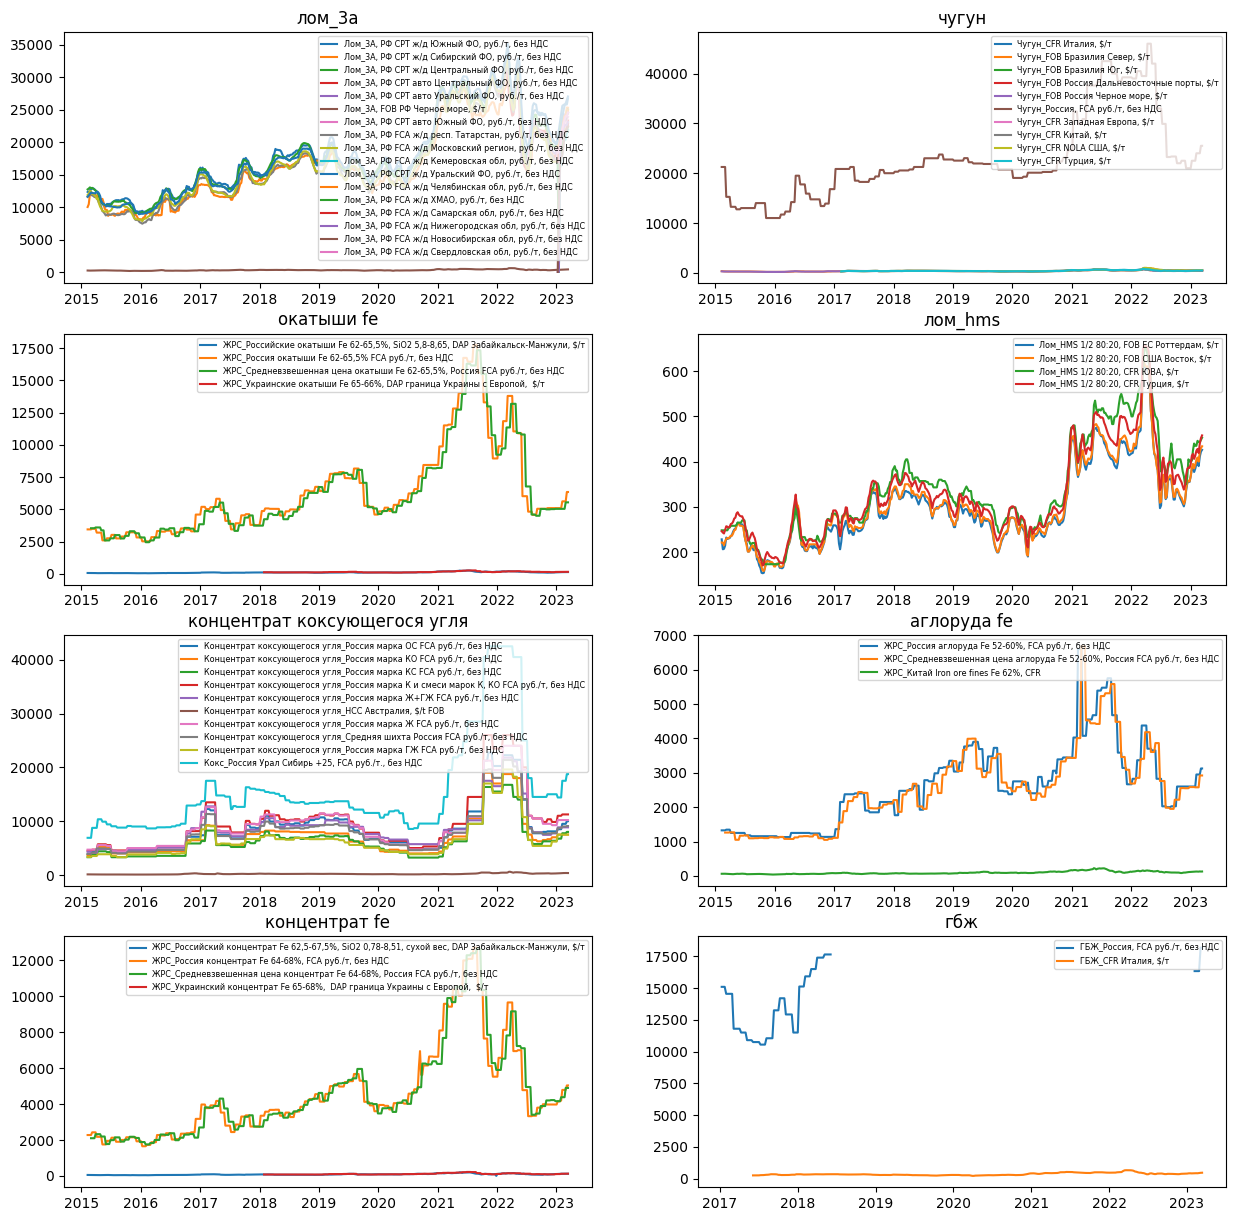

In [35]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

for ax, group in zip(axs.flat, groups.keys()):
    ax.plot(price["dt"], price[groups[group]])
    ax.set_title(group)
    ax.legend(groups[group], loc="upper right", fontsize="xx-small")

Дейсвительно, как можно заметить, товары одной группы имеют очень схожое распредление (зарубежные производители находят отдельно, в долларах)

In [36]:
severstal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1054 non-null   object
 1   Price     1054 non-null   object
 2   Open      1054 non-null   object
 3   High      1054 non-null   object
 4   Low       1054 non-null   object
 5   Vol.      1053 non-null   object
 6   Change %  1054 non-null   object
dtypes: object(7)
memory usage: 57.8+ KB


In [37]:
def normalize(data):
    for col in data.columns[1:5]:
        if isinstance(data.loc[:, col][0], str):
            data.loc[:, col] = data.loc[:, col].str.replace(",", "").astype(float)
    for col in data.columns[5:]:
        data.loc[:, col] = data.loc[:, col].str.replace(",", ".")
    data.loc[:, "Change %"] = data.loc[:, "Change %"].str.replace("%", "").astype(float)
    temp_vol = []
    for value in data["Vol."]:
        if value is np.nan:
            temp_vol.append(np.nan)
        elif value.endswith("K"):
            temp_vol.append(float(value[:-1]) / 1000)
        elif value.endswith("M"):
            temp_vol.append(float(value[:-1]))
    data.loc[:, "Vol."] = temp_vol
    return data

In [38]:
novolipetsk.loc[:, "Date"] = pd.to_datetime(novolipetsk["Date"], format="%m/%d/%Y")
severstal.loc[:, "Date"] = pd.to_datetime(severstal["Date"], format="%m/%d/%Y")
magnitogorsk.loc[:, "Date"] = pd.to_datetime(magnitogorsk["Date"], format="%d.%m.%Y")

severstal = normalize(severstal)
magnitogorsk = normalize(magnitogorsk)
novolipetsk = normalize(novolipetsk)

In [39]:
severstal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1054 non-null   datetime64[ns]
 1   Price     1054 non-null   float64       
 2   Open      1054 non-null   float64       
 3   High      1054 non-null   float64       
 4   Low       1054 non-null   float64       
 5   Vol.      1053 non-null   float64       
 6   Change %  1054 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 57.8 KB


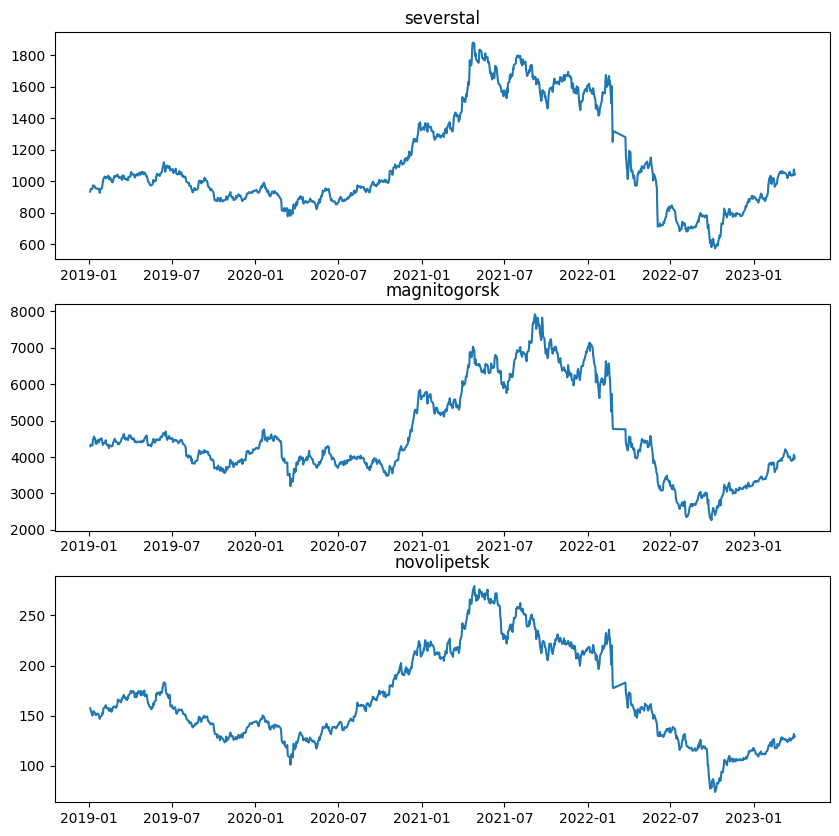

In [41]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

for ax, name, title in zip(axs.flat, [severstal, magnitogorsk, novolipetsk], ["severstal", "magnitogorsk", "novolipetsk"]):
    ax.plot(name["Date"], name["Price"])
    ax.set_title(title)

Заметим, что курсы акций схожи, обладают относительно одинаковой изменчивостью, не имеют ярко выраженного тренда

In [42]:
value = severstal.iloc[severstal[severstal["Vol."].isna()].index[0] - 1, -2]
severstal = severstal.fillna(value)

In [43]:
for name,title in zip([severstal, magnitogorsk, novolipetsk], ['severstal', 'magnitogorsk', 'novolipetsk']):
    for col in name.columns[1:]:
        print(f"{title}:p-val={adfuller(name[col])[1]}, data = {title}, col = {col}")

severstal:p-val=0.5945607140627444, data = severstal, col = Price
severstal:p-val=0.6311821040384876, data = severstal, col = Open
severstal:p-val=0.5009586414106383, data = severstal, col = High
severstal:p-val=0.5440637051007668, data = severstal, col = Low
severstal:p-val=1.2408916542333445e-12, data = severstal, col = Vol.
severstal:p-val=8.635418365904927e-15, data = severstal, col = Change %
magnitogorsk:p-val=0.5844111203273189, data = magnitogorsk, col = Price
magnitogorsk:p-val=0.6064414347139735, data = magnitogorsk, col = Open
magnitogorsk:p-val=0.3884401874860727, data = magnitogorsk, col = High
magnitogorsk:p-val=0.5502074143433502, data = magnitogorsk, col = Low
magnitogorsk:p-val=0.03411545735926538, data = magnitogorsk, col = Vol.
magnitogorsk:p-val=2.766927442673052e-26, data = magnitogorsk, col = Change %
novolipetsk:p-val=0.6092687039353162, data = novolipetsk, col = Price
novolipetsk:p-val=0.6262664111899406, data = novolipetsk, col = Open
novolipetsk:p-val=0.639188

Стационарны только объёмы продаж по каждой акции и процентное изменение (что логично)

Данные конкретно ПО ЦЕНАМ акций имеют очень схожее распредление в пределах одной акции

По итогу EDA имеем:
- ошибка случайна, ярко выраженной сезонности не наблюдается.
- данные рынка сырья: данные в основном цикличны, что может влиять на стоимость арматуры 
- индекс LMЕ -> слабый тренд, сезонность присутствует
- макропараметры: Действительно, как оказалось, БИПЦ измеряется в последний день текущего месяца (только с 2021 года), после чего меняет свою периодичнсоть; необходимо будет восстановить значения данного показателя, так как о нём почти ничего неизвестно; Курс доллара обладает неоднородным периодом измерений; Дискретность ставки нестрашна, достаточно всего лишь доопределить её на неизвестных участках константной функцией
- показатели рынка металла: цены сильно разнятся + разброс цен тоже, половина рядов нестационарна, на сезонность тяжело проверять; надо подумать над агреграциями по компании, например
- цены на топливо: очень похожи, маленький разброс, ярко выраженный восходящий тренд;
- цены на сырьё: группы товаров (лом, уголь и т.д.) имеют очень схожое распределение вне зависимости от производящей компании -> посмотреть на ВР для каждой группы
- акции данные имеют схожую структуру, большой диапазон значений